In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [2]:
def get_training_data(df, date=None):
    if date is not None:
        df = df[df.date < date]
    # X, y
    to_remove = ['outcome', 'name_1', 'name_2', 'date', 'level'] + ['B365_1', 'EX_1', 'LB_1',
                                                                    'CB_1', 'GB_1',  'IW_1', 'SB_1', 'SB_2', 'IW_2', 'GB_2', 'CB_2', 'LB_2', 'EX_2', 'B365_2']
    X_cols = [col for col in df if col not in to_remove]

    return df[X_cols], df["outcome"]


In [3]:
# Constructs a correlation martrix plot
def correlation_map(X, title):
    corr = X.corr()
    plt.subplots(figsize=(50, 50))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, cmap=cmap, linewidths=.5)
    plt.savefig(title)

In [4]:
# Contructs histograms
from sklearn import preprocessing
def hist_plot(X, title): 
    _X = X.replace([np.inf, -np.inf], 0).dropna()
    X_scaled = pd.DataFrame(preprocessing.scale(_X), columns=X.columns)
    X_scaled.hist(bins=100, figsize=(50, 50))
    plt.savefig(title)

In [5]:
def time_discounting_plot(yearly_factors=[0.5, 0.6, 0.7, 0.8, 0.9], weekly_factors=np.arange(.991, .999, 0.002)):
    # Year plot
    years = np.arange(0, 6)
    plt.subplots(figsize=(10, 10))
    for f in reversed(yearly_factors):
        yy = np.power(np.repeat(f, len(years)), years)
        plt.bar(years, yy)
        
    plt.legend(reversed(yearly_factors))
    plt.xlabel("Years")
    plt.ylabel("Weight")
    plt.savefig("yearly.pdf")

    # Week plot
    weeks = np.arange(0, 200)
    plt.subplots(figsize=(10, 10))
    for f in reversed(weekly_factors):
        yy = np.power(np.repeat(f, len(weeks)), weeks)
        plt.plot(weeks, yy)
        
    plt.legend(reversed(weekly_factors))
    plt.xlabel("Weeks")
    plt.ylabel("Weight")
    plt.savefig("weekly.pdf")


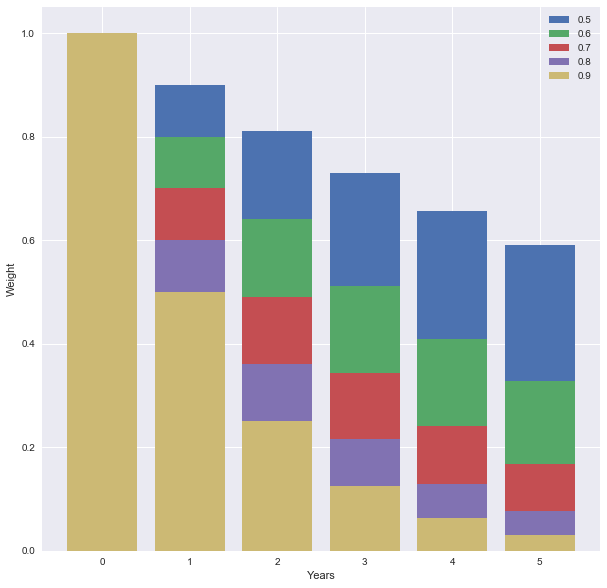

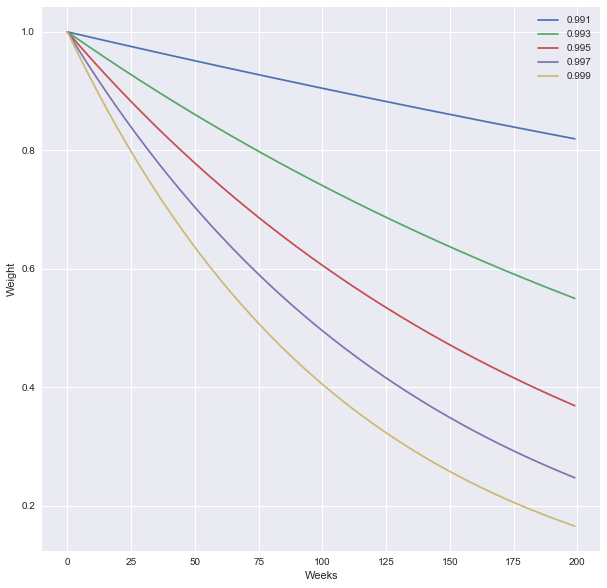

In [6]:
time_discounting_plot()

In [7]:
prefix = 'final_datasets/'
datasets = [prefix + 'prepared' + str(i) + '.csv' for i in range(11)]

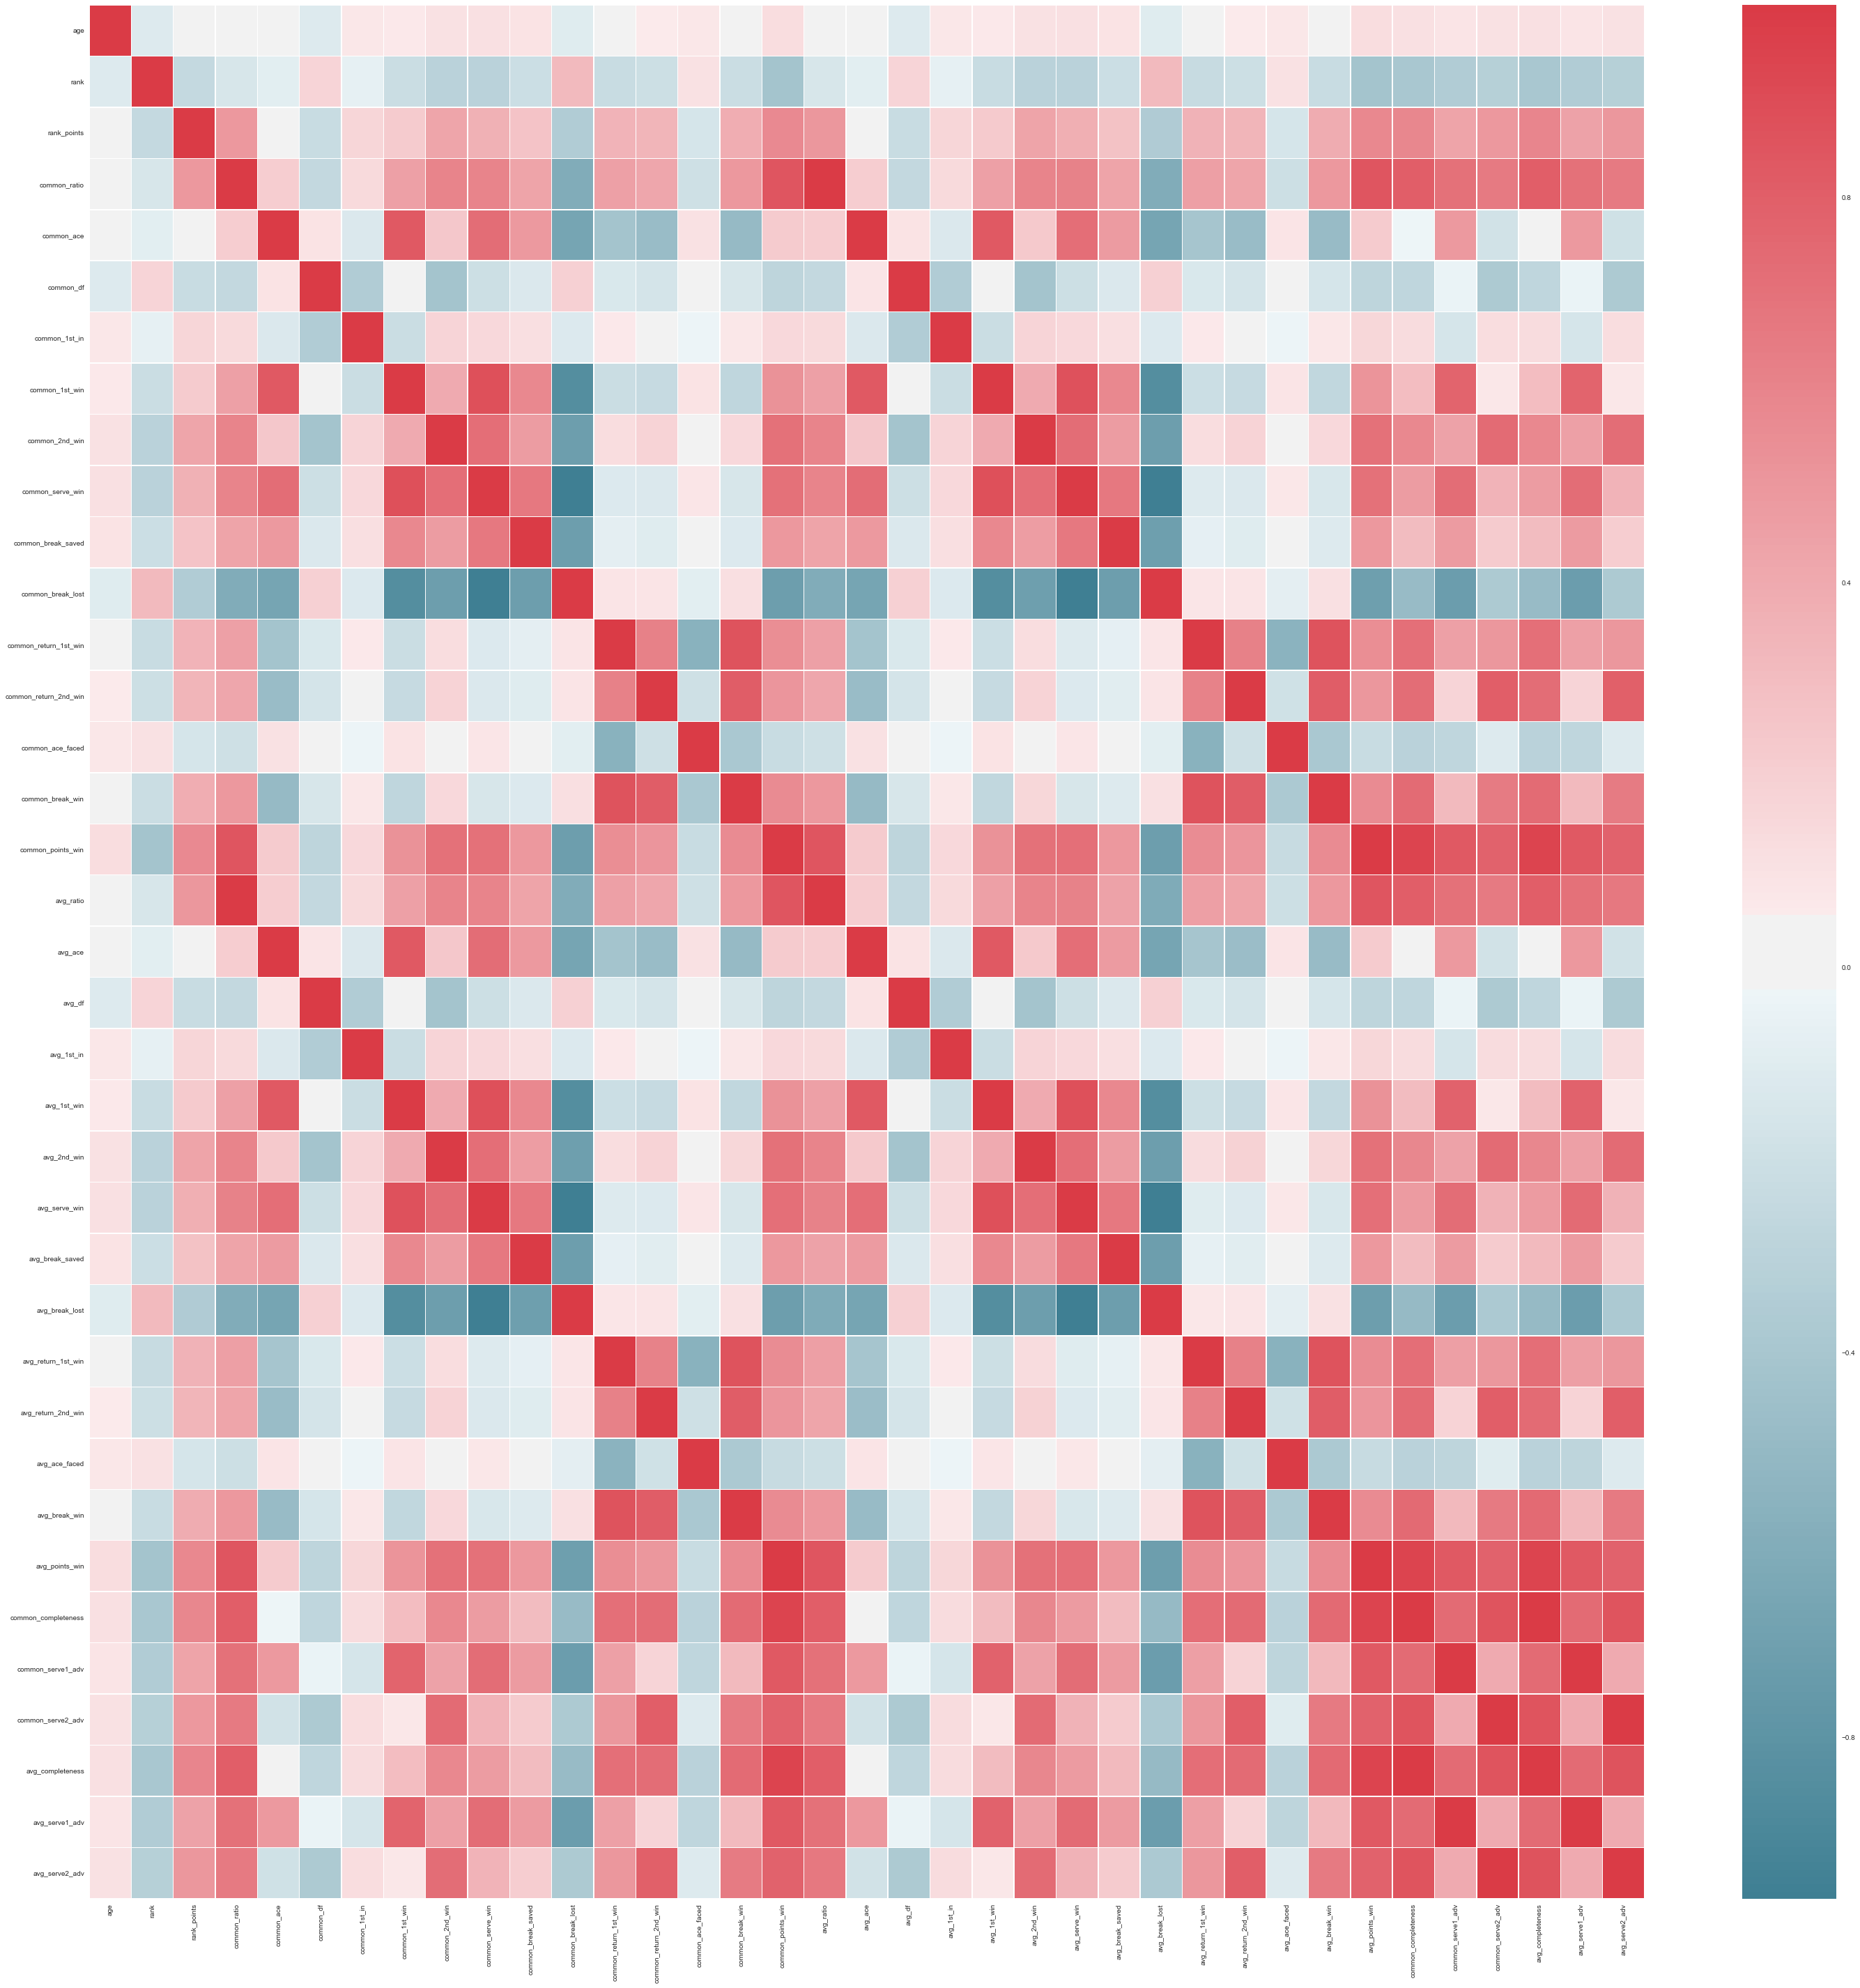

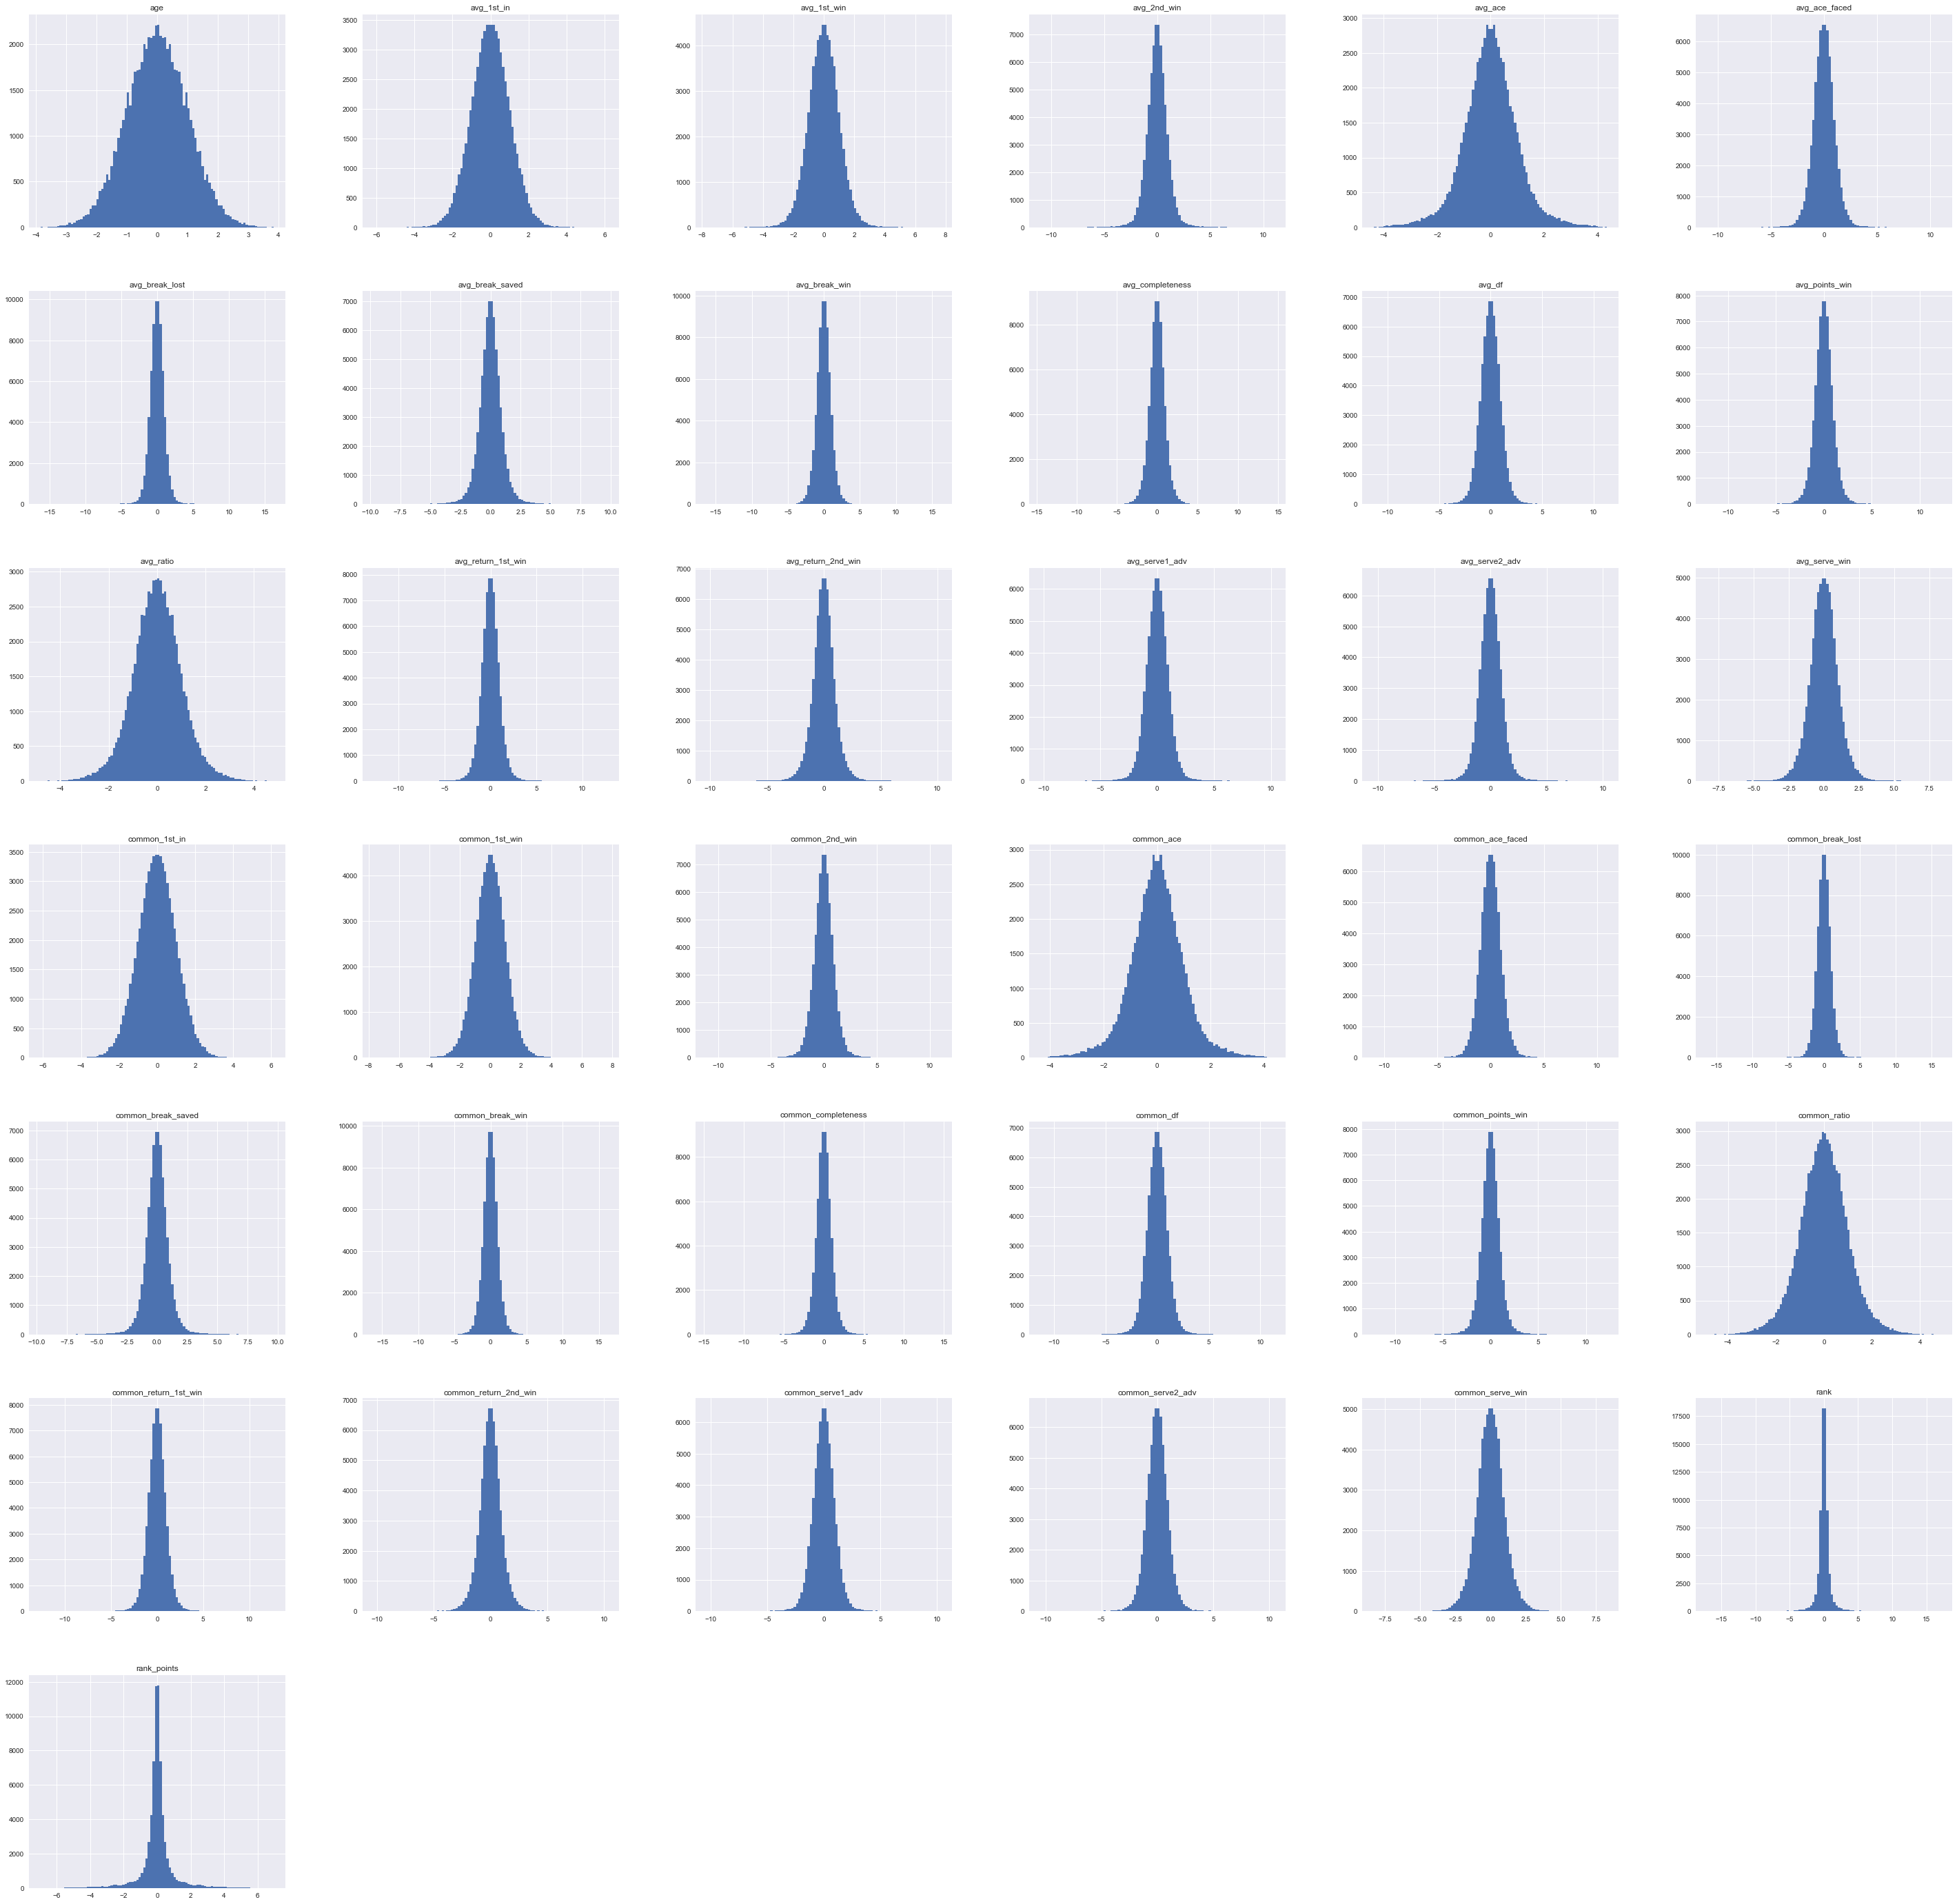

In [8]:
df = pd.read_csv(datasets[7], index_col=None, header=0, low_memory=False)
df = df.drop(['ht'],axis=1)
df['date'] = pd.to_datetime(df['date'], format="%Y/%m/%d")
df.sort_values(by='date', inplace=True)
X, y = get_training_data(df)
correlation_map(X, "correlation_final.pdf")
hist_plot(X, "histograms.pdf")

In [9]:
def seasons_split(df, start_year, end_year, debut):

    years = end_year - (start_year + debut)
    start_date = '{}-01-01'.format(start_year)
    indices = years * [None]

    for y in range(years):
        end_train_date = '{}-01-01'.format(start_year+debut+y+1)
        end_test_date = '{}-01-01'.format(start_year+debut+y+2)

        n_train = df[(df.date >= start_date) & (df.date < end_train_date)].shape[0]
        n_test = df[(df.date >= end_train_date) & (df.date < end_test_date)].shape[0]

        indices[y] = (list(range(n_train)), list(range(n_train, n_train+n_test)))

    return indices


def seasons_split_by_level(df, start_year, end_year, debut, level):

    years = end_year - (start_year + debut)
    start_date = '{}-01-01'.format(start_year)
    indices = years * [None]

    for y in range(years):
        end_train_date = '{}-01-01'.format(start_year+debut+y+1)
        end_test_date = '{}-01-01'.format(start_year+debut+y+2)

        n_train = df[(df.date >= start_date) & (df.date < end_train_date)].shape[0]

        test = df[(df.date >= end_train_date) & (df.date < end_test_date)
                  & (df.level == level)].index.tolist()

        indices[y] = (list(range(n_train)), test)

    return indices

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

In [11]:
# Baseline
from sklearn.metrics import accuracy_score

df.index = pd.RangeIndex(len(df.index))
X, y = get_training_data(df)
splits = seasons_split(df, 2005, 2017, debut=2)
weights = np.array([len(s[1])/sum(list(map(len, splits))) for s in splits])

scores_baseline = []

for s in splits:
    test = s[1]
    X_test = X.values[test, 1] # rank column
    y_test = y.values[test]
    y_pred = np.where(X_test < 0, 1, 0) 
    scores_baseline.append(accuracy_score(y_test, y_pred))
    
avg, std = weighted_avg_and_std(scores_baseline, weights=weights)    

print("Baseline Accuracy: {}±{}".format(avg, std))

Baseline Accuracy: 0.6691813804173355±0.007441958297287174


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [25]:
weekly = np.arange(.991, .999, 0.002)
yearly = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [41]:
# LR
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

prefix = 'final_datasets/'
datasets = [prefix + 'prepared' + str(i) + '.csv' for i in range(11)]
avg_lr, std_lr = [], []

for dataset in datasets:
    df = pd.read_csv(dataset, index_col=None, header=0, low_memory=False)
    df = df.drop(['ht'],axis=1).replace([np.inf, -np.inf], 0).dropna()
    df['date'] = pd.to_datetime(df['date'], format="%Y/%m/%d")
    df.sort_values(by='date', inplace=True)
    df.index = pd.RangeIndex(len(df.index))
    X, y = get_training_data(df)
    splits = seasons_split(df, 2005, 2017, debut=2)
    weights = np.array([len(s[1])/sum(list(map(len, splits))) for s in splits])

    lr = LogisticRegression(penalty='l1', max_iter=1000)
    sc = cross_val_score(lr, X.values, y.values, cv=splits, scoring='neg_log_loss')
    

    _avg_lr, _std_lr = weighted_avg_and_std(sc, weights=weights)   # week, year
    avg_lr.append(_avg_lr) 
    std_lr.append(_std_lr)

    print("LR Accuracy: {}±{}".format(_avg_lr, _std_lr))


LR Accuracy: -0.5924774441180741±0.012382177185177947
LR Accuracy: -0.5922857986962617±0.012432502041284871
LR Accuracy: -0.5923862477367751±0.012313030173391167
LR Accuracy: -0.5925518712180293±0.012181930660280676
LR Accuracy: -0.5932084426422032±0.012066464865828684
LR Accuracy: -0.5933445778473072±0.012472944363808752
LR Accuracy: -0.5926570979185263±0.012389551358278373
LR Accuracy: -0.5922618167633451±0.012321691992030707
LR Accuracy: -0.5923669722643474±0.01228851558952637
LR Accuracy: -0.5928287206114438±0.012095651524649592
LR Accuracy: -0.5936640867482549±0.012249269844239248


In [26]:
avg_lr, std_lr, weekly

([0.682265915449772,
  0.682572534590472,
  0.6818059867387222,
  0.6810394388869725,
  0.6803495458203979,
  0.6815760223831973,
  0.6826875167682342,
  0.6824575524127093,
  0.6817676593461348,
  0.6805028553907478,
  0.6803495458203979],
 [0.013703972568898541,
  0.014023121496829539,
  0.01464840689962836,
  0.01457566720074787,
  0.014616177426033572,
  0.012116263401407732,
  0.013554829173658052,
  0.01403082841109694,
  0.014532628930882106,
  0.01452208572181065,
  0.014907608094948977],
 array([0.991, 0.993, 0.995, 0.997, 0.999]))

In [29]:
np.array(avg_lr[0:len(weekly)])
np.array(std_lr[0:len(weekly)])

array([0.01370397, 0.01402312, 0.01464841, 0.01457567, 0.01461618])

Text(0.5,0,'Yearly discount factor')

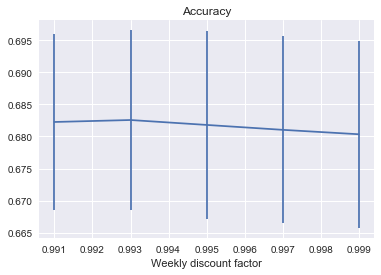

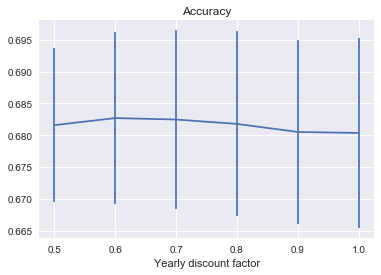

In [36]:
# Plots 
plt.errorbar(weekly, np.array(avg_lr[0:len(weekly)]), np.array(std_lr[0:len(weekly)]))
plt.title("Accuracy")
plt.xlabel("Weekly discount factor")

plt.figure()
plt.errorbar(yearly, np.array(avg_lr[len(weekly):]), np.array(std_lr[len(weekly):]))
plt.title("Accuracy")
plt.xlabel("Yearly discount factor")

In [ ]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

prefix = 'final_datasets/'
datasets = [prefix + 'prepared' + str(i) + '.csv' for i in range(11)]
scores_lda = []

for dataset in datasets:
    df = pd.read_csv(dataset, index_col=None, header=0, low_memory=False)
    df = df.drop(['ht'],axis=1).replace([np.inf, -np.inf], 0).dropna()
    df['date'] = pd.to_datetime(df['date'], format="%Y/%m/%d")
    df.sort_values(by='date', inplace=True)
    df.index = pd.RangeIndex(len(df.index))
    X, y = get_training_data(df)
    splits = seasons_split(df, 2005, 2017, debut=2)
    weights = np.array([len(s[1])/sum(list(map(len, splits))) for s in splits])

    lda = LinearDiscriminantAnalysis(solver='lsqr')
    sc = cross_val_score(lda, X.values, y.values, cv=splits)

    avg_lda, std_lda = weighted_avg_and_std(sc, weights=weights)    
    scores_lda.append(sc)

    print("LDA Accuracy: {}±{}".format(avg_lda, std_lda))

In [ ]:
# RFs
from sklearn.ensemble import RandomForestClassifier

prefix = 'final_datasets/'
datasets = [prefix + 'prepared' + str(i) + '.csv' for i in range(11)]
scores_rf = []

for dataset in datasets:
    df = pd.read_csv(dataset, index_col=None, header=0, low_memory=False)
    df = df.drop(['ht'],axis=1).replace([np.inf, -np.inf], 0).dropna()
    df['date'] = pd.to_datetime(df['date'], format="%Y/%m/%d")
    df.sort_values(by='date', inplace=True)
    df.index = pd.RangeIndex(len(df.index))
    X, y = get_training_data(df)
    splits = seasons_split(df, 2005, 2017, debut=2)
    weights = np.array([len(s[1])/total_test for s in splits])

    rf = RandomForestClassifier(n_estimators=100, max_depth=12, n_jobs=-1)
    scores_rf.append(cross_val_score(rf, X.values, y.values, cv=splits))

    avg, std = weighted_avg_and_std(scores_rf, weights=weights)    

    print("RF Accuracy: {}±{}".format(avg, std))